In [2]:
import pandas as pd

## Task 1: Classification Model - Predicting the Success or Failure of a Campaign

### Part 1: Data Preprocessing

In [4]:
#Import data
ks=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/INSY 662 - Data Mining/Kickstarter.xlsx")

In [5]:
ks.head()

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19 09:31:29,2016-03-19 09:31:32,...,18,2015,3,2,18,2016,9,62,30,30
1,556771080,SmartPi - Turn your Raspberry Pi into a SmartM...,9000.0,16552.0,successful,False,DE,EUR,2016-04-03 08:05:09,2016-04-03 08:05:10,...,8,2016,9,2,18,2016,8,9,45,45
2,839314928,PlantSitter - The World's Smartest Plant Monit...,60000.0,43234.0,canceled,False,US,USD,2016-03-29 08:01:08,2016-03-28 09:46:41,...,31,2016,5,2,18,2016,8,18,40,39
3,681077916,Digital Video LUT Box for Colorblindness Corre...,125000.0,1262.0,canceled,False,US,USD,2016-03-19 07:48:02,2016-02-23 09:30:28,...,28,2016,11,2,18,2016,7,20,30,5
4,1315415013,help send Object Collection to Norway!,2000.0,2300.0,successful,False,US,USD,2016-03-03 17:00:00,2016-03-03 17:00:00,...,16,2016,10,2,18,2016,7,1,14,14


In [6]:
#Setting up the data
#We only want to classify a project as "successful" or "failed"
ks=ks[ks.state != "canceled"]
ks=ks[ks.state!="suspended"]

In [7]:
#Replace blanks in category column
ks["category"]=ks["category"].fillna("Other")

In [8]:
#Reset indexing
ks=ks.reset_index(drop=True)

In [9]:
#Drop data that we are confident is irrelevant
#This includes data captured after the launch & data that is irrelevant to project details
ks=ks.drop(["id","name", "pledged","currency","deadline","state_changed_at","created_at",
           "launched_at", "static_usd_rate","name_len", "name_len_clean","blurb_len",
           "blurb_len_clean","state_changed_at_weekday","created_at_weekday","deadline_day",
           "deadline_hr","state_changed_at_month","state_changed_at_day", "state_changed_at_yr", 
           "state_changed_at_hr", "created_at_day", "created_at_hr","launched_at_day", "launched_at_hr", 
           "launch_to_state_change_days"], axis=1)

In [10]:
#Data Pre-processing
x=pd.get_dummies(ks.drop(["state"],axis=1),drop_first=True)
y=ks["state"]

In [11]:
#Double check for any null values
x.isnull().values.any()

False

In [12]:
#Standardize with Robust Scaler
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()
x_rb = rb.fit_transform(x)
x_rb=pd.DataFrame(x_rb, columns=x.columns)

### Part 2: PCA Feature Selection

In [14]:
#Feature selection with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=52)
pca.fit(x_rb)
variance=pca.explained_variance_ratio_

variance=list(variance)
total=0
countr=0
for i in variance: #select predictors that capture 95% of the variance
    if total<0.95:
        total+=i
        countr+=1
#The number of predictors is 2

pca = PCA(n_components=countr)
pca.fit(x_rb)
x_rb_pca = pca.transform(x_rb)

### Part 3: Building A Classification Model with KNN 

In [15]:
#Train and test sets
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain, ytest=train_test_split(x_rb_pca, y, test_size = 0.3, random_state = 0)

In [16]:
#Find the optimal K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neighbors = []
cv_scores = []
for i in range (1,40,2):
    neighbors.append(i)
    knn = KNeighborsClassifier(n_neighbors=i, p=2, weights="distance")
    scores = cross_val_score(knn, xtrain, ytrain, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
optimal_k

33

In [17]:
#Build KNN
knn = KNeighborsClassifier(n_neighbors=optimal_k,p=2, weights="distance")
model_knn_pca = knn.fit(xtrain,ytrain)
y_test_pred = model_knn_pca.predict(xtest)

In [20]:
#Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy_knn_pca = accuracy_score(ytest, y_test_pred)
print("The accuracy of this model is", round(accuracy_knn_pca*100,2),"%")

The accuracy of this model is 96.18 %


### Part 4: Evaluating the Model with Alternate Dataset 

In [21]:
#Setting up the data
ks_grading_sample=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/INSY 662 - Data Mining/Kickstarter-Grading-Sample.xlsx")

In [22]:
#We only want to classify a project as "successful" or "failed"
ks_grading_sample=ks_grading_sample[ks_grading_sample.state != "canceled"]
ks_grading_sample=ks_grading_sample[ks_grading_sample.state!="suspended"]

In [23]:
#Replace blanks in category column
ks_grading_sample["category"]=ks_grading_sample["category"].fillna("Other")

In [24]:
#Reset indexing
ks_grading_sample=ks_grading_sample.reset_index(drop=True)

In [25]:
#Drop data that we are confident is irrelevant
#This includes data captured after the launch & data that is irrelevant to project details
ks_grading_sample=ks_grading_sample.drop(["id","name", "pledged","currency","deadline","state_changed_at","created_at",
                            "launched_at", "static_usd_rate","name_len", "name_len_clean","blurb_len",
                            "blurb_len_clean","state_changed_at_weekday","created_at_weekday","deadline_day",
                            "deadline_hr","state_changed_at_month","state_changed_at_day", "state_changed_at_yr", 
                            "state_changed_at_hr", "created_at_day", "created_at_hr","launched_at_day", "launched_at_hr", 
                            "launch_to_state_change_days"], axis=1)

In [26]:
#Data Pre-processing
x_grading_sample=pd.get_dummies(ks_grading_sample.drop(["state"],axis=1),drop_first=True)
y_grading_sample=ks_grading_sample["state"]

In [27]:
#Double check for any null values
x_grading_sample.isnull().values.any()

False

In [29]:
#Make Predictions
pca.fit(x_grading_sample)
x_grading_sample_pca = pca.transform(x_grading_sample)

ytestpred_grading_sample = model_knn_pca.predict(x_grading_sample_pca)
accuracy_knn_pca = accuracy_score(y_grading_sample, ytestpred_grading_sample)
print("The accuracy of this model on test data is", round(accuracy_knn_pca*100,2),"%")

The accuracy of this model on test data is 75.03 %


## Task 2: Clustering Model - Determining How Long Should A Campaign Last According to its Fundraising Goal

### Part 1: Data Preprocessing 

In [30]:
#Import Data
ks=pd.read_excel("C:/Users/rprat/OneDrive/Desktop/MMA Documents/INSY 662 - Data Mining/Kickstarter.xlsx")
ks=ks[ks.state != "canceled"]
ks=ks[ks.state!="suspended"]
ks=ks[ks.state!="failed"]
ks=ks.reset_index(drop=True)

x=ks[["goal","launch_to_deadline_days"]]

In [31]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

### Part 2: Building the Clustering Model with K-Means Clustering

In [32]:
#Find the optimal K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for i in range (2,10):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(x_std)
    labels = model.labels_
    print(i,':',silhouette_score(x_std,labels))

2 : 0.5940335358606044
3 : 0.5833848358199534
4 : 0.602811723784044
5 : 0.570192775055583
6 : 0.5877499123158522
7 : 0.598202191681622
8 : 0.6008825771483605
9 : 0.5476601896478004


In [33]:
#Cluster
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(x_std)
classify = model.predict(x_std)

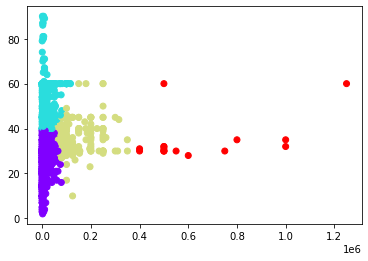

In [34]:
#Visualize
from matplotlib import pyplot
plot=pyplot.scatter(ks['goal'], ks['launch_to_deadline_days'],  c=model.labels_, cmap='rainbow')

In [35]:
#Evaluate clustering solution
silhouette_score(x_std, labels)

0.5476601896478004

Silhouette scores range between 1 and -1. The closer the score is to, the better it performs.

### Part 3: Inferring Insights 

In [36]:
#Defining Cluster sizes
cluster_map = pd.DataFrame()
cluster_map['data_index'] = ks.index.values
cluster_map['cluster'] = model.labels_
cluster_map

cluster0=cluster_map[cluster_map.cluster == 0]
cluster1=cluster_map[cluster_map.cluster == 1]
cluster2=cluster_map[cluster_map.cluster == 2]
cluster3=cluster_map[cluster_map.cluster == 3]

#Cluster 0
cluster0dataindex=cluster0["data_index"].tolist()
cluster0goaldata=[]
cluster0ltddata=[]
for i in cluster0dataindex:
    cluster0goaldata.append(x["goal"].loc[i])
for i in cluster0dataindex:
    cluster0ltddata.append(x["launch_to_deadline_days"].loc[i])
min(cluster0goaldata)
min(cluster0ltddata)
max(cluster0goaldata)
max(cluster0ltddata)

#Cluster 1
cluster1dataindex=cluster1["data_index"].tolist()
cluster1goaldata=[]
cluster1ltddata=[]
for i in cluster1dataindex:
    cluster1goaldata.append(x["goal"].loc[i])
for i in cluster1dataindex:
    cluster1ltddata.append(x["launch_to_deadline_days"].loc[i])
min(cluster1goaldata)
min(cluster1ltddata)
max(cluster1goaldata)
max(cluster1ltddata)

#Cluster 2
cluster2dataindex=cluster2["data_index"].tolist()
cluster2goaldata=[]
cluster2ltddata=[]
for i in cluster2dataindex:
    cluster2goaldata.append(x["goal"].loc[i])
for i in cluster2dataindex:
    cluster2ltddata.append(x["launch_to_deadline_days"].loc[i])
min(cluster2goaldata)
min(cluster2ltddata)
max(cluster2goaldata)
max(cluster2ltddata)

#Cluster 3
cluster3dataindex=cluster3["data_index"].tolist()
cluster3goaldata=[]
cluster3ltddata=[]
for i in cluster3dataindex:
    cluster3goaldata.append(x["goal"].loc[i])
for i in cluster3dataindex:
    cluster3ltddata.append(x["launch_to_deadline_days"].loc[i])
min(cluster3goaldata)
min(cluster3ltddata)
max(cluster3goaldata)
max(cluster3ltddata)

60